In [1]:
import jax
import jax.numpy as jnp

import optax
import jaxopt

import matplotlib.pyplot as plt

from gpax import ExactGP, RBFKernel, HomoscedasticNoise, ScalarMean
from gpax.utils import train_fn
from gpax.plotting import plot_posterior

import pprint
pp = pprint.PrettyPrinter(depth=4)

imported nosthenogpax version


(100, 1) (100,)


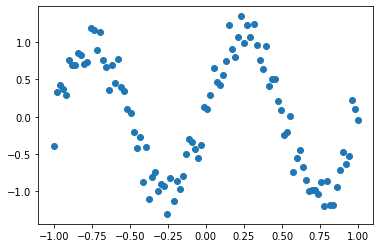

In [2]:
X = jnp.linspace(-1, 1, 100).reshape(-1, 1)
# X = jnp.concatenate([X[:40], X[60:]])
key = jax.random.PRNGKey(0)
y = jnp.sin(2 * jnp.pi * X) + jax.random.normal(key, X.shape)*0.2
y = y.ravel()

plt.scatter(X, y);
print(X.shape, y.shape)

## Exact GP

In [3]:
model = ExactGP(kernel=RBFKernel(), noise=HomoscedasticNoise(), mean=ScalarMean())
# OR
# model = ExactGP()

def loss_fun(raw_params):
    params = model.constrain(raw_params)
    return -model.log_probability(params, X, y)

key = jax.random.PRNGKey(123)
params = model.initialize_params(key, X)
pp.pprint(params)

{'kernel': {'lengthscale': DeviceArray([3.9904366], dtype=float32),
            'variance': DeviceArray(1.0967355, dtype=float32)},
 'mean': {'value': DeviceArray(-1.9906504, dtype=float32)},
 'noise': {'variance': DeviceArray(0.18806136, dtype=float32)}}


In [4]:
bijectors = model.get_bijectors()
pp.pprint(bijectors)

{'kernel': {'lengthscale': <gpax.bijectors.Exp object at 0x7f92f053c3a0>,
            'variance': <gpax.bijectors.Exp object at 0x7f92f053c460>},
 'mean': {'value': <gpax.bijectors.Identity object at 0x7f92f053c6d0>},
 'noise': {'variance': <gpax.bijectors.Exp object at 0x7f92f053cfa0>}}


In [5]:
params = model.initialize_params(key, X)
raw_params = model.unconstrain(params)

jax.grad(loss_fun)(raw_params)

{'kernel': {'lengthscale': DeviceArray([0.86609983], dtype=float32),
  'variance': DeviceArray(-2.0488818, dtype=float32)},
 'mean': {'value': DeviceArray(-1.8201141, dtype=float32)},
 'noise': {'variance': DeviceArray(-84.82228, dtype=float32)}}

dict_keys(['raw_params', 'raw_params_history', 'loss_history'])


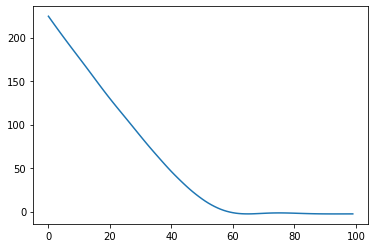

In [6]:
optimizer = optax.adam(learning_rate=0.1)
num_epochs = 100

key = jax.random.PRNGKey(42)
params = model.initialize_params(key, X)
raw_params = model.unconstrain(params)

result = train_fn(loss_fun, raw_params, optimizer, num_epochs=num_epochs)
print(result.keys())
# lbfgs_loss_fn = lambda params: loss_fun(constrain(params, bijectors))
# optimizer = jaxopt.ScipyMinimize(fun=lbfgs_loss_fn, method='L-BFGS-B')
# result = {}
# result["params"] = optimizer.run(params).params

plt.plot(result["loss_history"]);

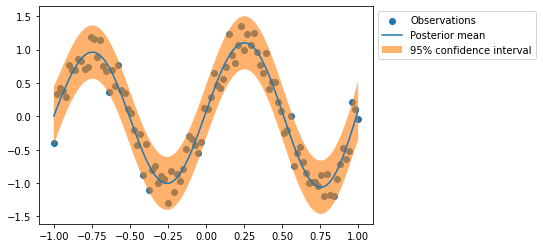

In [7]:
X_test = jnp.linspace(-1, 1, 200).reshape(-1, 1)
params = model.constrain(result["raw_params"])
pred_mean, pred_cov = model.predict(params, X, y, X_test)

ax = plot_posterior(X, y, X_test, pred_mean, pred_cov, ax=None, alpha=0.6);
ax.legend(bbox_to_anchor=(1,1));

## Sparse GP (Deprecated)

In [8]:
X_inducing = X[40:50]
model = SparseGP(
    kernel=RBFKernel(),
    noise=HomoscedasticNoise(),
    mean=ConstantMean(),
    method="vfe", # "vfe" or "fitc" or "dtc"
)


def loss_fun(params):
    return -model.elbo(params, X, y)

key = jax.random.PRNGKey(123)
params = model.initialize_params(key, X, X_inducing)
bijectors = model.get_bijectors()

optimizer = optax.adam(1e-1)
num_epochs = 100

params = unconstrain(params, bijectors)
params = randomize(params, key)
result = train_fn(loss_fun, params, bijectors, optimizer, num_epochs=num_epochs)

plt.plot(result["loss_history"]);

NameError: name 'SparseGP' is not defined

In [ ]:
params = constrain(result["params"], bijectors)
ax = plot_posterior(model, params, X, y, X_test, ax=None, alpha=0.6)
f = model.get_gp(params)
pseudo_obs = model.get_pseudo_obs(params, f, X, y)
ax.plot(params['X_inducing'], B.dense(pseudo_obs.mu(f.measure)), 'o', color='red', label='pseudo obs');
ax.legend(bbox_to_anchor=(1,1));